<a href="https://colab.research.google.com/github/Seifcha/BIRD-bank-agentic-data-mapping/blob/main/BIRD_streamlit_mapping_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚙️ À propos de ce notebook

Ce notebook contient un prototype interactif développé avec Streamlit pour tester et valider un système de matching sémantique entre des attributs client et ceux de la base Bird.

Le schéma ci-dessous illustre de manière synthétique le **flux de traitement** du prototype, en mettant en évidence les différentes étapes — depuis la récupération des fichiers jusqu’à l’évaluation et la validation des correspondanceset la visualisation des résultats finaux.
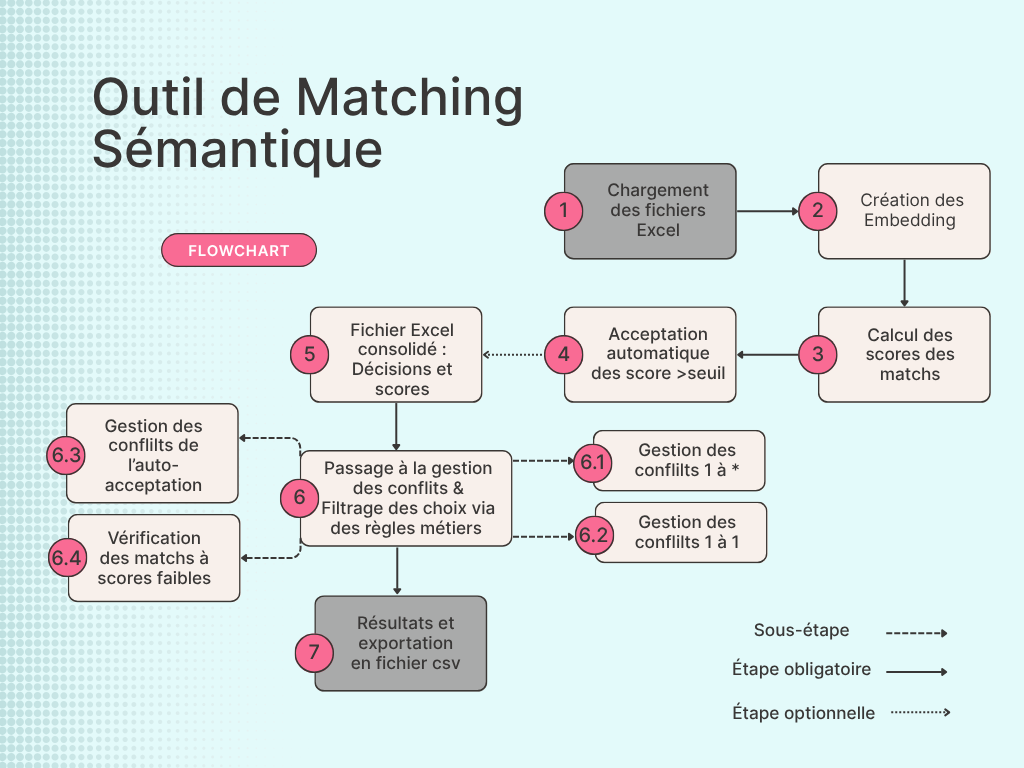

Chaque cellule **%%writefile** représente un fichier Python du projet.



Pour exécuter l'interface Streamlit (la cellule après app.py à la fin),  cliquez sur le lien affiché et puis validez.

📁 Organisation des fichiers

Voici une brève description des fichiers principaux :

app.py : point d'entrée principal de l'application Streamlit.

loaddata.py : gestion du chargement des fichiers client et BIRD.

contextualization.py : préparation textuelle des attributs pour la similarité.

matching.py : génération des similarités avec des embeddings.

ponderation.py : application de pondérations métier sur les scores.

decision.py : logique d’acceptation automatique selon seuils.

gestionConflict.py / interaction.py : résolution des conflits manuels.

gestionAutoConflict.py : traitement des conflits auto-détectés.

lowscore.py / gestionLowScore.py : traitement des scores faibles.

gestionResultat.py : affichage des résultats finaux.

reset.py : bouton de réinitialisation de l’état.

utils.py : fonctions utilitaires diverses (navigation, conversion, etc.).

birdInfos.py : récupération d’informations depuis les APIs BIRD.

initialisationChatBot.py / birdChatBot.py : configuration d’un expert BIRD intelligent avec RAG via Gemini.

ponderation.py, reset.py, utils.py : fonctions utilitaires diverses.

🔧 Bibliothèques utilisées

sentence_transformers (all-MiniLM-L6-v2) : pour générer des embeddings textuels efficaces pour les deux langues, rapides et peu coûteux en mémoire.

torch, numpy, pandas : traitement numérique et manipulation des données.

streamlit : interface utilisateur rapide et interactive pour prototyper.

requests : pour interroger les APIs BIRD.

langchain, langchain_google_genai : pour intégrer un LLM Gemini dans l’application.

xlsxwriter, io.BytesIO : pour exporter les résultats en Excel.

collections.defaultdict, re : utilitaires Python natifs pour le traitement des structures.

**Pourquoi ces choix techniques ?**

Gemini 2.0 Flash : rapide, gratuit, et performant pour des tâches de vérification sémantique.

Produit scalaire (inner product) : plus efficace que la similarité cosinus dans certains cas d’optimisation vectorielle.

Streamlit : parfait pour créer rapidement des prototypes interactifs sans infrastructure complexe.


=> Ce prototype vous permet de tester manuellement et automatiquement le processus de matching, avec un accompagnement visuel et interactif via Streamlit.


In [ ]:
!pip install pandas sentence-transformers scikit-learn openpyxl odfpy streamlit torch pyngrok

In [ ]:
!pip install deep-translator
#c'est pour la translation de fr vers

In [ ]:
%%writefile imports.py
#%%writefile est pour créer un fichier | chaque cellule fait référence à un fichier independant
#ce fichier est pour les importation qui seront utilsées après
import streamlit as st
import pandas as pd
from collections import defaultdict
from sentence_transformers import SentenceTransformer, util
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity



Overwriting imports.py


# Fichiers Utilitaires - Configuration de Base

Ce fichier contient les **utilitaires fondamentaux** de l'application :

## Configuration de l'interface Streamlit
- **Titre de la page** : "Outil de Correspondance de Données"
- **Layout** : Format large pour afficher plusieurs colonnes de données

##  Règles Métier (BUSINESS_RULES)
Ces règles définissent les **incompatibilités sémantiques** entre types d'attributs :

**Exemple concret :**
- Un attribut `montant` (numérique) ne peut PAS correspondre à un attribut `date` (temporel)
- Un attribut `code` (identifiant) ne peut PAS correspondre à une `description` (textuel)

**Pourquoi c'est important ?**
- Évite les fausses correspondances (ex: "ID_CLIENT" → "DATE_CREATION")
- Améliore la qualité du matching automatique
- Respecte la logique métier bancaire

##  Initialisation de l'État de Session
Streamlit utilise `st.session_state` pour **mémoriser les données** entre les interactions utilisateur :
- `final_matches` : Correspondances validées définitivement
- `pending_conflicts` : Correspondances ambiguës en attente de décision
- `processed_attrs` : Attributs déjà traités (évite les doublons)

In [ ]:
%%writefile utils.py
# Sauvegarde le script dans un fichier nommé utils.py
from imports import * # Importe tous les modules définis dans le fichier imports.py


# Configuration de base de la page Streamlit
st.set_page_config(page_title="Data Matching Tool", layout="wide")  # Définition du titre et du format de la page
st.title("🔄 Outil de Correspondance de Données")  # Titre affiché en haut de la page


# Règles métier – définissent les attributs à exclure lors de la comparaison, selon le contexte de l'attribut source
BUSINESS_RULES = {
    'montant': ['date', 'code', 'statut', 'id', 'number', 'numéro', 'texte', 'description'],
    'amount': ['date', 'code', 'statut', 'id', 'number', 'numéro', 'texte', 'description'],
    'valeur': ['date', 'code', 'statut', 'id', 'number', 'numéro', 'texte', 'description'],
    'prix': ['date', 'code', 'statut', 'id', 'number', 'numéro', 'texte', 'description'],
    'quantité': ['date', 'code', 'statut', 'id', 'number', 'numéro', 'texte', 'description'],
    'value': ['date', 'code', 'statut', 'id', 'number', 'numéro', 'texte', 'description'],
    'quant': ['date', 'code', 'statut', 'id', 'number', 'numéro', 'texte', 'description'],
    'date': ['montant', 'amount', 'valeur', 'prix', 'quantité', 'value', 'quant'],
    'age': ['montant', 'amount', 'valeur', 'prix', 'quantité', 'value', 'quant'],
    'temps': ['montant', 'amount', 'valeur', 'prix', 'quantité', 'value', 'quant'],
    'code': ['description', 'libellé', 'texte', 'comment', 'note', 'montant', 'amount', 'valeur'],
    'id': ['description', 'libellé', 'texte', 'comment', 'note', 'montant', 'amount', 'valeur'],
    'number': ['description', 'libellé', 'texte', 'comment', 'note', 'montant', 'amount', 'valeur'],
    'numéro': ['description', 'libellé', 'texte', 'comment', 'note', 'montant', 'amount', 'valeur'],
    'description': ['code', 'id', 'number', 'numéro', 'montant', 'amount', 'valeur', 'date', 'age'],
    'libellé': ['code', 'id', 'number', 'numéro', 'montant', 'amount', 'valeur', 'date', 'age'],
    'texte': ['code', 'id', 'number', 'numéro', 'montant', 'amount', 'valeur', 'date', 'age'],
    'comment': ['code', 'id', 'number', 'numéro', 'montant', 'amount', 'valeur', 'date', 'age'],
    'note': ['code', 'id', 'number', 'numéro', 'montant', 'amount', 'valeur', 'date', 'age']
}

# Initialisation de l'état
if 'final_matches' not in st.session_state:
    st.session_state.final_matches = pd.DataFrame(columns=[
        'attribut_client', 'table_client', 'description_client',
        'attribut_bird', 'entity_bird', 'description_bird',
        'score', 'status', 'decision', 'metric'
    ])
if 'resolved_items' not in st.session_state:
    st.session_state.resolved_items = set()
if 'pending_conflicts' not in st.session_state:
    st.session_state.pending_conflicts = {}
if 'pending_low_scores' not in st.session_state:
    st.session_state.pending_low_scores = {}
if 'processed_attrs' not in st.session_state:
    st.session_state.processed_attrs = set()
if 'current_step' not in st.session_state:
    st.session_state.current_step = 'upload'
if 'processed_low_scores' not in st.session_state:
    st.session_state.processed_low_scores = set()

Overwriting utils.py


In [ ]:
%%writefile reset.py
from imports import st,pd # Importation de Streamlit et Pandas depuis le fichier "imports"


# Fonction pour réinitialiser complètement l'état de l'application Streamlit
def reset_state():
  # Réinitialisation du DataFrame des correspondances finales
    # (correspondances validées, rejetées ou en attente)
    st.session_state.final_matches = pd.DataFrame(columns=[
        'attribut_client', 'table_client', 'description_client',
        'attribut_bird', 'entity_bird', 'description_bird',
        'score', 'status', 'decision', 'metric'
    ])
    # Réinitialise la liste des éléments déjà traités (ex: conflits résolus)
    st.session_state.resolved_items = set()

    # Réinitialise les conflits en attente de traitement
    st.session_state.pending_conflicts = {}

    # Réinitialise les correspondances à faible score en attente de validation
    st.session_state.pending_low_scores = {}

    # Réinitialise les attributs déjà traités (évite les doublons)
    st.session_state.processed_attrs = set()

    # Réinitialise les scores faibles déjà traités
    st.session_state.processed_low_scores = set()

    # Réinitialise l'étape actuelle de l'application à "upload" (étape initiale)
    st.session_state.current_step = 'upload'


Overwriting reset.py


#  Chargement des Données - Import des Fichiers Excel

##  Objectif
Charger et valider les **métadonnées** des deux systèmes à comparer :
1. **Fichier Client** : Vos attributs internes
2. **Fichier BIRD** : Référentiel bancaire européen

##  Structure Attendue

### Fichier Client
| Colonne | Description | Exemple |
|---------|-------------|---------|
| `Nom_attribut` | Nom technique d'un attribut | `customer_id` |
| `Description` | Description métier | `Identifiant unique du client` |
| `Nom_objet` | Table/Entité source | `Customers` |
| `Type` | Type de données | `INTEGER` |

### Fichier BIRD
| Colonne | Description | Exemple |
|---------|-------------|---------|
| `attribute name` | Nom officiel BIRD | `counterparty_identifier` |
| `attribute description` | Définition réglementaire | `Unique identifier of counterparty` |
| `entity name` | Entité BIRD | `Counterparty` |
| `data type` | Type officiel | `String` |

## ⚠️ Validation Automatique
Le système vérifie automatiquement la présence de toutes les colonnes requises et **arrête l'exécution** si une colonne manque.

In [ ]:
%%writefile loaddata.py
from imports import st,pd

# Fonction de chargement des données avec mise en cache automatique pour améliorer les performances
@st.cache_data  # Streamlit mettra en cache le résultat tant que le fichier ne change pas
def load_data(uploaded_file, source):
        # Lecture du fichier Excel uploadé par l'utilisateur
    df = pd.read_excel(uploaded_file)
    if source == 'client':
        # Pour le fichier du client, on attend ces colonnes spécifiques
        required = ['Nom_attribut', 'Description', 'Nom_objet', 'Type']
    else:
        # Pour le fichier de référence (Bird), on attend ces colonnes
        required = ['attribute name', 'attribute description', 'entity name', 'data type']

    # Vérification des colonnes manquantes dans le fichier importé
    missing = [col for col in required if col not in df.columns]

    # Si des colonnes attendues sont absentes, affichage d'une erreur et arrêt de l'exécution
    if missing:
        st.error(f"Colonnes manquantes: {', '.join(missing)}")# Affiche les colonnes absentes
        st.stop()  # Arrête l'exécution de l'application Streamlit

    # Si tout est OK, retourne le DataFrame chargé
    return df

Overwriting loaddata.py


#  Système de Correspondances - Classe Match


##  Structure d'un Match
Chaque correspondance contient :

### Informations Client
- `client_attr` : Nom de votre attribut
- `client_desc` : Description de votre attribut  
- `client_table` : Table source

### Informations BIRD
- `bird_attr` : Nom de l'attribut BIRD
- `bird_desc` : Description officielle BIRD
- `bird_entity` : Entité BIRD

### Métriques de Qualité
- `score` : Score de similarité (0 à 1, plus c'est haut, mieux c'est)
- `metric` : Méthode de calcul ("Inner Product")
- `status` : État actuel ("pending", "accepted", "rejected")

In [ ]:
%%writefile matching.py
# Enregistre ce script dans un fichier matching.py
from imports import pd


class Match:
    def __init__(self, client_idx, bird_idx, score, df_client, df_bird, metric):
        """
        Initialise un objet Match représentant une correspondance entre un attribut client et un attribut Bird.

        :param client_idx: Index de la ligne dans le DataFrame client
        :param bird_idx: Index de la ligne dans le DataFrame Bird
        :param score: Score de similarité entre les deux attributs
        :param df_client: DataFrame contenant les données client
        :param df_bird: DataFrame contenant les données Bird
        :param metric: Méthode de calcul de similarité (ex. 'cosine', 'jaccard')
        """
        self.client_idx = client_idx
        self.bird_idx = bird_idx
        self.score = score
        self.df_client = df_client
        self.df_bird = df_bird
        self.metric = metric

     # Propriété pour retourner le nom de l’attribut client
    @property
    def client_attr(self):
        return self.df_client.iloc[self.client_idx]['Nom_attribut']

    # Propriété pour retourner le nom de l’attribut Bird
    @property
    def bird_attr(self):
        return self.df_bird.iloc[self.bird_idx]['attribute name']

    # Propriété pour retourner la description de l’attribut client (vide si NaN)
    @property
    def client_desc(self):
        desc = self.df_client.iloc[self.client_idx]['Description']
        return desc if pd.notna(desc) else ""

    # Propriété pour retourner la description de l’attribut Bird (vide si NaN)
    @property
    def bird_desc(self):
        desc = self.df_bird.iloc[self.bird_idx]['attribute description']
        return desc if pd.notna(desc) else ""

    # Propriété pour retourner le nom de la table (ou entité) côté client
    @property
    def client_table(self):
        return self.df_client.iloc[self.client_idx]['Nom_objet']

    # Propriété pour retourner le nom de l’entité côté Bird
    @property
    def bird_entity(self):
        return self.df_bird.iloc[self.bird_idx]['entity name']

    # Convertit l’objet Match en dictionnaire exploitable
    def to_dict(self):
        return {
            'attribut_client': self.client_attr,
            'table_client': self.client_table,
            'description_client': self.client_desc,
            'attribut_bird': self.bird_attr,
            'entity_bird': self.bird_entity,
            'description_bird': self.bird_desc,
            'score': float(self.score),     # Conversion explicite du score en float (au cas où ce soit un numpy type)
            'status': 'pending',            # Statut initial de la correspondance
            'decision': None,               # Décision utilisateur ou système (sera définie plus tard)
            'metric': self.metric           # Métrique utilisée pour le calcul de similarité
        }


Overwriting matching.py


In [ ]:
%%writefile validation.py
from utils import *
def is_valid_match(client_attr, bird_attr, client_desc, bird_desc):
    """Vérifie si une correspondance est valide selon les règles métier"""
    client_attr_lower = client_attr.lower() if client_attr else ""
    bird_attr_lower = bird_attr.lower() if bird_attr else ""
    client_desc_lower = client_desc.lower() if client_desc else ""
    bird_desc_lower = bird_desc.lower() if bird_desc else ""

    # Vérifier les règles d'incompatibilité
    for keyword, incompatible_terms in BUSINESS_RULES.items():
        # Si le mot-clé est dans l'attribut ou la description client
        if keyword in client_attr_lower or keyword in client_desc_lower:
            # Vérifier si des termes incompatibles sont dans l'attribut ou description BIRD
            for term in incompatible_terms:
                if term in bird_attr_lower or term in bird_desc_lower:
                    return False
#inversement

        # Si le mot-clé est dans l'attribut ou la description BIRD
        if keyword in bird_attr_lower or keyword in bird_desc_lower:
            # Vérifier si des termes incompatibles sont dans l'attribut ou description client
            for term in incompatible_terms:
                if term in client_attr_lower or term in client_desc_lower:
                    return False

    return True


Overwriting validation.py


#  Système de Pondération - Amélioration Intelligente des Scores

##  Pourquoi Pondérer ?
Les scores bruts du modèle d'embedding ne suffisent pas, puisque on est en train de comparer deux langues (fr vs an) ! Il faut **ajuster selon le contexte métier**.


##Ce fichier gère la traduction FR→EN et la pondération des scores de similarité.

# Fonctions :
 - translate_text(text) : traduit un texte unique du français vers l’anglais avec MarianMT.
 - batch_translate(texts) : traduit en une seule requête une liste de textes pour améliorer les performances.
 - batch_translate_df(df_client) : traduit en batch les colonnes clés du DataFrame client
   afin d’éviter de retraduire les mêmes valeurs à chaque étape de comparaison.
 - calculate_weighted_score(match) : ajuste le score d’un match en appliquant des bonus
   (correspondances exactes, partielles, descriptions similaires) et des pénalités
  (types de données incompatibles) en utilisant les données déjà traduites.


##  Bonus Appliqués

###  Correspondance Exacte (+0.15)
customer_id ↔ customer_id = +15% de bonus

###  Correspondance Partielle (+0.08)
customer_id ↔ customer_identifier = +8% de bonus

###  Descriptions Similaires (+0.03 par mot commun)
"Identifiant client" ↔ "Client identifier" = +6% (2 mots communs)

##  Pénalités Appliquées

###  Types Incompatibles (-0.1)
STRING ↔ DATE = -10% de pénalité


In [ ]:
%%writefile ponderation.py
from validation import *
from transformers import MarianMTModel, MarianTokenizer
import torch
from imports import pd,st

# ====== Chargement du modèle FR->EN une seule fois ======
model_name = "Helsinki-NLP/opus-mt-fr-en"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)

def translate_text(text):
    """Traduction rapide FR->EN via MarianMT (texte unique)"""
    if not text:
        return ""
    batch = tokenizer([text], return_tensors="pt", padding=True, truncation=True).to(device)
    translated = model.generate(**batch, max_length=512)
    return tokenizer.decode(translated[0], skip_special_tokens=True).lower()

def batch_translate(texts):
    """Traduction groupée de plusieurs textes FR->EN"""
    if not texts:
        return []
    batch = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    translated = model.generate(**batch, max_length=512)
    return [t.lower() for t in tokenizer.batch_decode(translated, skip_special_tokens=True)]

def batch_translate_df(df_client):
    """
    Traduit toutes les colonnes pertinentes du DataFrame client vers l'anglais
    pour éviter les traductions répétées lors de la pondération.
    """
    df_translated = df_client.copy()

    for col in ["Nom_attribut", "Description", "Nom_objet", "Type"]:
        if col in df_client.columns:
            df_translated[col] = batch_translate(df_client[col].fillna("").astype(str).tolist())

    return df_translated

def calculate_weighted_score(match):
    """Calcule un score pondéré basé sur les règles métier"""
    base_score = match.score

# Récupérer la version traduite depuis st.session_state si dispo
    try:
        import streamlit as st
        df_client_translated = st.session_state.df_client_translated
    except:
        df_client_translated = match.df_client  # fallback si pas de traduction dispo

 # Attributs et descriptions déjà traduits
    client_attr_en = df_client_translated.iloc[match.client_idx]['Nom_attribut']
    bird_attr_en = match.bird_attr.lower()

    # Bonus pour les correspondances exactes de noms
    if client_attr_en == bird_attr_en:
        base_score += 0.15  # Augmenté car très significatif

    # Bonus pour les correspondances partielles de noms
    elif client_attr_en in bird_attr_en or bird_attr_en in client_attr_en:
        base_score += 0.08  # Augmenté car significatif

#traduction des descriptions clients
    client_desc_en = df_client_translated.iloc[match.client_idx]['Description']
    bird_desc_en = match.bird_desc.lower()

    # Comparaison des descriptions
    if client_desc_en and bird_desc_en:
        common_words = set(client_desc_en.split()) & set(bird_desc_en.split())
        if len(common_words) > 2:
           # Mots communs dans les descriptions originales
            base_score += 0.03 * min(len(common_words), 5)

        if len(common_words) > 2:
            base_score += 0.03 * min(len(common_words), 5)  # Bonus proportionnel

    # Pénalité si les types de données sont incompatibles
    client_type = str(match.df_client.iloc[match.client_idx]['Type']).lower() if 'Type' in match.df_client.columns else ''
    bird_type = str(match.df_bird.iloc[match.bird_idx]['data type']).lower() if 'data type' in match.df_bird.columns else ''

    if client_type and bird_type:
        type_pairs = [
          # Types numériques
          ('int', 'integer'),
          ('int', 'number'),
          ('int', 'numeric'),
          ('float', 'int'),
          ('float', 'decimal'),
          ('float', 'number'),
          ('float', 'numeric'),
          ('double', 'number'),
          ('long', 'integer'),

          # Types texte
          ('string', 'text'),
          ('string', 'varchar'),
          ('string', 'char'),
          ('string', 'str'),
          ('text', 'varchar'),

          # Types date/heure
          ('date', 'datetime'),
          ('date', 'timestamp'),
          ('date', 'date'),
          ('datetime', 'timestamp'),
          ('time', 'timestamp'),

          # Types booléens
          ('bool', 'boolean'),
          ('boolean', 'bit'),


      ]

        type_compatible = False
        for pair in type_pairs:
            if (pair[0] in client_type and pair[1] in bird_type) or (pair[1] in client_type and pair[0] in bird_type):
                type_compatible = True
                break

        if not type_compatible:
            base_score -= 0.1  # Pénalité pour types incompatibles


    return min(max(base_score, 0), 1.0)  # Assurer que le score est entre 0 et 1.0

Overwriting ponderation.py


In [ ]:
%%writefile decision.py
from imports import st,pd

# Fonction pour ajouter une correspondance acceptée à l'état global de l'application
def add_accepted_match(match, decision):
    """
    Ajoute une correspondance acceptée à la table des matches finaux dans la session Streamlit.

    :param match: Objet Match (défini dans matching.py)
    :param decision: Décision prise par l'utilisateur (ex: "Accepté manuellement", "Validé automatiquement")
    """
    new_row = match.to_dict()
    new_row['status'] = 'accepted'      # Marquer comme accepté
    new_row['decision'] = decision      # Ajouter la justification ou source de décision

    # Vérifier si cette correspondance existe déjà pour éviter les doublons
    existing = st.session_state.final_matches[
        (st.session_state.final_matches['attribut_client'] == new_row['attribut_client']) &
        (st.session_state.final_matches['attribut_bird'] == new_row['attribut_bird'])
    ]

    # Si la correspondance n’existe pas encore, on l’ajoute
    if existing.empty:
        st.session_state.final_matches = pd.concat([
            st.session_state.final_matches,
            pd.DataFrame([new_row])  # On l’ajoute sous forme de DataFrame d’une seule ligne
        ], ignore_index=True)

        # On note que cette paire client-bird a été résolue pour ne pas la reproposer plus tard

        st.session_state.resolved_items.add((match.client_attr, match.bird_attr))
        st.success("Correspondance ajoutée!")

Overwriting decision.py


In [ ]:
%%writefile gestionConflict.py
from imports import st
def get_unique_matches(match_list):
    """
    Filtre une liste de correspondances pour ne conserver qu'une seule correspondance
    par attribut Bird .

    :param match_list: liste d'objets Match
    :return: liste d'objets Match uniques, triée par score décroissant
    """
    unique_matches = {}
    for match in match_list:
      # Clé basée sur l’attribut Bird et sa description
        key = (match.bird_attr, match.bird_desc)

         # Si cette clé n'existe pas encore ou que ce match a un score supérieur,
        # on redéfinit l’entrée
        if key not in unique_matches or match.score > unique_matches[key].score:
            unique_matches[key] = match
    return sorted(unique_matches.values(), key=lambda x: -x.score)

def get_conflicting_matches(matches):
    """
    Identifie les correspondances en « conflit » : celles dont le score est
    suffisamment proche du meilleur score pour être considérées ambiguës.

    :param matches: liste d’objets Match
    :return: sous-liste de matches en conflit
    """
    if not matches:
        return []

    # Trier par score décroissant
    sorted_matches = sorted(matches, key=lambda x: x.score, reverse=True)
    best_score = sorted_matches[0].score #le score le plus haut dans les choix
    conflict_matches = []

    for match in sorted_matches:
        # Accéder au differences entre les choix via session_state
        if best_score - match.score < st.session_state.CONFLICT_DIFF_THRESHOLD:
            conflict_matches.append(match)
        # Si la différence avec le score maximal est inférieure au seuil,
        # on considère qu'il y a un conflit


    return conflict_matches

Overwriting gestionConflict.py


In [ ]:
%%writefile gestionAutoConflict.py
from ponderation import *
from imports import st,pd

def handle_auto_conflicts():
    """
    Permet à l'utilisateur de résoudre manuellement les conflits de correspondances
    automatiquement identifiés comme ambiguës (taguées 'auto_conflict').
    """


    # Extraire tous les attributs clients qui ont des correspondances marquées comme 'auto_conflict'
    conflict_items = st.session_state.final_matches[
        (st.session_state.final_matches['decision'] == 'auto_conflict')
    ]['attribut_client'].unique()

    # Si aucun conflit détecté
    if not conflict_items.size:
        st.success("Aucun conflit auto-accepté à résoudre !")
        return

    # Interface Streamlit : menu déroulant pour choisir un attribut client avec conflit
    current_conflict = st.selectbox(
        "Sélectionnez un attribut client à résoudre",
        sorted(conflict_items)
    )

    # Filtrer les matches en conflit pour cet attribut
    conflicts_df = st.session_state.final_matches[
        (st.session_state.final_matches['attribut_client'] == current_conflict) &
        (st.session_state.final_matches['decision'] == 'auto_conflict')
    ]

    st.write(f"Plusieurs correspondances valides pour : **{current_conflict}**")

    # Widget multi-sélection
    selected_indices = st.multiselect(
        "Sélectionnez les correspondances à garder",
        options=conflicts_df.index,
        format_func=lambda x: f"{conflicts_df.loc[x, 'attribut_bird']} (score: {conflicts_df.loc[x, 'score']:.2f})"
    )

    # Bouton de confirmation
    if st.button("Garder les matches sélectionnés", key=f"keep_matches_{current_conflict}"):
        # Supprimer tous les matches en conflit pour cet attribut
        st.session_state.final_matches = st.session_state.final_matches[
            ~((st.session_state.final_matches['attribut_client'] == current_conflict) &
              (st.session_state.final_matches['decision'] == 'auto_conflict'))
        ]

        # Ajout des correspondances sélectionnées comme résolues manuellement
        for idx in selected_indices:
            selected_row = conflicts_df.loc[idx].copy()
            selected_row['decision'] = 'manual_resolution'
            st.session_state.final_matches = pd.concat([
                st.session_state.final_matches,
                pd.DataFrame([selected_row])
            ], ignore_index=True)

        st.success(f"{len(selected_indices)} correspondance(s) enregistrée(s) pour {current_conflict} !")
        st.rerun() # Recharge la page pour actualiser l’état

def add_potential_match(match, conflict_type="auto_conflict"):
    """
    Ajoute une correspondance identifiée comme ambiguë ou nécessitant une validation manuelle.

    :param match: objet Match
    :param conflict_type: type de conflit à taguer ('auto_conflict', 'low_score', etc.)
    """
    # Convertit le match en dictionnaire avec infos supplémentaires

    new_row = match.to_dict()
    new_row.update({
        'status': 'potential',              # Statut non validé
        'decision': conflict_type,         # Raisons du conflit
        'resolution_date': None,           # Champ à remplir plus tard
        'resolved_by': None                # Pour audit trail futur
    })

    # Éviter les doublons : vérifier si la même correspondance existe déjà
    existing = st.session_state.final_matches[
        (st.session_state.final_matches['attribut_client'] == new_row['attribut_client']) &
        (st.session_state.final_matches['attribut_bird'] == new_row['attribut_bird'])
    ]

    # Si la correspondance n’existe pas déjà, on l’ajoute
    if existing.empty:
        st.session_state.final_matches = pd.concat([
            st.session_state.final_matches,
            pd.DataFrame([new_row])
        ], ignore_index=True)

Overwriting gestionAutoConflict.py


In [ ]:
%%writefile contextualization.py
from imports import re,pd

def prepare_texts(df, source):
    """
    Prépare une liste de textes formatés à partir d'un DataFrame, selon la source spécifiée ('client' ou autre).

    Arguments :
    - df : pandas.DataFrame contenant les données des attributs.
    - source : str, détermine le format à utiliser ('client' ou autre).

    Retourne :
    - texts : liste de chaînes de caractères, chacune représentant un attribut sous forme textuelle unifiée.
    """

    texts = []
    for _, row in df.iterrows():

        # Si la source est 'client', on utilise les noms de colonnes spécifiques à ce format
        if source == 'client':
            text = (f"Attribut: {row['Nom_attribut']} "
                   f"| Description: {row['Description'] if pd.notna(row['Description']) else ''} "
                   f"| Table: {row['Nom_objet']} "
                   f"| Type: {row['Type']}")
        else:
          # Sinon, la source est BIRD, donc on utilise les noms de colonnes spécifiques à BIRD
            text = (f"Attribute: {row['attribute name']} "
                   f"| Description: {row['attribute description'] if pd.notna(row['attribute description']) else ''} "
                   f"| Entity: {row['entity name']} "
                   f"| Type: {row['data type']}")

        # Nettoyage du texte : suppression des caractères spéciaux (non alphanumériques), conversion en minuscules
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        texts.append(text)
    return texts

Overwriting contextualization.py


In [ ]:
%%writefile lowscore.py
from validation import *
from ponderation import *
from imports import st
from matching import *
from gestionConflict import get_unique_matches

def get_low_score_matches(df_client, df_bird, similarity_scores, metric_name):
    """
    Cette fonction extrait les correspondances (matchs) entre les attributs des clients et ceux de BIRD
    dont le score de similarité est considéré comme "faible", mais suffisamment intéressant pour être analysé.
    Le score doit être compris entre LOW_SCORE_MIN et LOW_SCORE_MAX (définis dans st.session_state).
    """
    matches = []

    # Parcourir toutes les combinaisons client/bird pour vérifier les scores
    for i in range(len(df_client)):
        for j in range(len(df_bird)):
            raw_score = similarity_scores[i][j]

            #Créer le match d'abord
            match = Match(i, j, raw_score, df_client, df_bird, metric_name)

            # Vérification si le match est pertinent via les règles métier
            if is_valid_match(match.client_attr, match.bird_attr, match.client_desc, match.bird_desc):
                # Appliquer la pondération
                weighted_score = calculate_weighted_score(match)
                match.score = weighted_score

                # Maintenant la vérification des seuils avec le score pondéré
                if (st.session_state.LOW_SCORE_MIN <= weighted_score) and (weighted_score <= st.session_state.LOW_SCORE_MAX):
                    matches.append(match)

    # Dictionnaire pour filtrer les doublons et ne garder que le meilleur match pour chaque paire
    unique_matches = get_unique_matches(matches)

    # Retourne la liste des matchs triés par score décroissant
    return unique_matches

Overwriting lowscore.py


## 🧑‍💻 Interface interactive avec Streamlit

Ce bloc utilise **Streamlit** pour créer une interface permettant de comparer un attribut client avec un attribut BIRD.  
Il affiche les correspondances trouvées avec leurs scores de similarité, et permet à l'utilisateur d’accepter ou refuser ces correspondances.


In [ ]:
%%writefile interaction.py
from lowscore import *
from imports import st
from decision import *
from contextualization import *
from matching import *
from collections import defaultdict
from gestionConflict import *
from gestionAutoConflict import *

def handle_conflicts(CONFLICT_MIN, CONFLICT_MAX, AUTO_ACCEPT_MIN):
    """
    Gère les conflits de correspondances (scores intermédiaires) entre attributs client et BIRD.
    Deux cas sont traités :
    - Les correspondances uniques (non conflictuelles) → acceptation ou rejet.
    - Les correspondances multiples (conflits) → choix manuel.
    """

    st.write(f"**Correspondances avec scores entre {CONFLICT_MIN} et {CONFLICT_MAX} nécessitant une décision**")

    # Regrouper tous les conflits par attribut client
    conflicts_by_attr = defaultdict(list)          # Pour les vrais conflits
    single_matches_by_attr = defaultdict(list)     # Pour les correspondances uniques non conflictuelles

    # Parcourir chaque attribut client
    for i in range(len(st.session_state.df_client)):
        matches = []

        # Parcourir chaque attribut BIRD pour évaluer le score de similarité
        for j in range(len(st.session_state.df_bird)):
            raw_score = st.session_state.similarity_scores[i][j]

            # Création du match d'abord pour pouvoir calculer le score pondéré
            match = Match(i, j, raw_score,
                         st.session_state.df_client,
                         st.session_state.df_bird,
                         st.session_state.metric_name)

            # Application des règles métier et la pondération EN PREMIER
            if is_valid_match(match.client_attr, match.bird_attr, match.client_desc, match.bird_desc):
                # Calcul du score pondéré
                weighted_score = calculate_weighted_score(match)
                match.score = weighted_score

                #Maintenant vérification des seuils avec le score pondéré
                if (CONFLICT_MIN <= weighted_score) and (weighted_score < CONFLICT_MAX):
                    matches.append(match)

        # Gestion après évaluation de toutes les correspondances pour un attribut client
        if matches:
            client_attr = matches[0].client_attr

            # Obtenir les correspondances uniques
            unique_matches = get_unique_matches(matches)

            # Si plusieurs correspondances possibles alors c'est un conflit
            if len(unique_matches) > 1:
                conflict_matches = get_conflicting_matches(unique_matches)
                if conflict_matches and len(conflict_matches) > 1:
                    conflicts_by_attr[client_attr].extend(conflict_matches)
                else:
                    # Si pas de vrai conflit, prendre la meilleure correspondance
                    single_matches_by_attr[client_attr] = unique_matches[0]
            else:
                # Une seule correspondance, l'ajouter aux correspondances uniques
                single_matches_by_attr[client_attr] = unique_matches[0]

    # === TRAITEMENT DES CORRESPONDANCES UNIQUES (pas de vrai conflit) ===
    for client_attr, match in single_matches_by_attr.items():
        if client_attr not in st.session_state.processed_attrs:
            st.info(f"Correspondance unique trouvée pour '{client_attr}' → '{match.bird_attr}' (score: {match.score:.3f})")

            col1, col2 = st.columns(2)
            with col1:
                st.write("**Attribut Client:**")
                st.write(f"- Nom: {match.client_attr}")
                st.write(f"- Description: {match.client_desc}")
                st.write(f"- Table: {match.client_table}")

            with col2:
                st.write("**Attribut BIRD:**")
                st.write(f"- Nom: {match.bird_attr}")
                st.write(f"- Description: {match.bird_desc}")
                st.write(f"- Entity: {match.bird_entity}")



            col3, col4 = st.columns(2)
            with col3:
              # Acceptation directe de la correspondance
                if st.button(f"Accepter cette correspondance", key=f"accept_single_{client_attr}"):
                    add_accepted_match(match, "accepted_single_match")
                    st.session_state.processed_attrs.add(client_attr)
                    st.rerun()

                # Rejet de la correspondance
            with col4:
                if st.button(f" Rejeter cette correspondance", key=f"reject_single_{client_attr}"):
                    st.session_state.processed_attrs.add(client_attr)
                    st.session_state.resolved_items.add((match.client_attr, match.bird_attr))
                    st.rerun()

            st.markdown("---")

    # Traiter les vrais conflits (plusieurs options)
    for client_attr, matches in conflicts_by_attr.items():
        if client_attr in st.session_state.processed_attrs:
            continue

        conflict_key = f"conflict_{client_attr}"


        # Stocker les données du conflit dans la session si pas encore fait
        if conflict_key not in st.session_state.pending_conflicts:
            st.session_state.pending_conflicts[conflict_key] = {
                'matches': get_unique_matches(matches),
                'decision': None
            }

        conflict_data = st.session_state.pending_conflicts[conflict_key]
        unique_matches = conflict_data['matches']

        with st.expander(f"Conflit multiple: {client_attr}", expanded=True):
            st.write("**Attribut Client:**")
            st.write(f"- Nom: {client_attr}")
            st.write(f"- Description: {unique_matches[0].client_desc}")
            st.write(f"- Table: {unique_matches[0].client_table}")

            st.write("**Options BIRD disponibles:**")

# Afficher chaque option possible
            for i, match in enumerate(unique_matches, 1):
                st.write(f"{i}. **{match.bird_attr}** (score pondéré: {match.score:.3f})")
                st.write(f"   - Description: {match.bird_desc}")
                st.write(f"   - Entity: {match.bird_entity}")
                st.write("")

# Choix de l'action à effectuer
            decision = st.radio(
                "Action:",
                ["Accepter une option", "Accepter plusieurs options", "Ignorer tout"],
                key=f"decision_{client_attr}"
            )

            if decision == "Accepter une option":
                option = st.selectbox(
                    "Choisir une option",
                    range(1, len(unique_matches)+1),
                    format_func=lambda x: f"Option {x}: {unique_matches[x-1].bird_attr} (score: {unique_matches[x-1].score:.3f})",
                    key=f"option_{client_attr}"
                )
                if st.button("Valider", key=f"validate_single_{client_attr}"):
                    add_accepted_match(unique_matches[option-1], "accepted_single_conflict")
                    st.session_state.processed_attrs.add(client_attr)
                    st.rerun()

            elif decision == "Accepter plusieurs options":
                options = st.multiselect(
                    "Choisir les options",
                    range(len(unique_matches)),
                    format_func=lambda x: f"{unique_matches[x].bird_attr} (score: {unique_matches[x].score:.3f})",
                    key=f"multi_{client_attr}"
                )
                if st.button("Valider", key=f"validate_multi_{client_attr}"):
                    for idx in options:
                        add_accepted_match(unique_matches[idx], "accepted_multiple_conflict")
                    st.session_state.processed_attrs.add(client_attr)
                    st.rerun()

            elif decision == "Ignorer tout":
                if st.button("Confirmer l'ignorance", key=f"ignore_{client_attr}"):
                    st.session_state.processed_attrs.add(client_attr)
                    st.session_state.resolved_items.update(
                        (match.client_attr, match.bird_attr) for match in unique_matches
                    )
                    st.rerun()

    # Vérifier si on peut passer à l'étape suivante
    total_items = len(conflicts_by_attr) + len(single_matches_by_attr)
    if total_items == 0:
        st.success("Aucune correspondance dans la plage de scores conflictuels!")
        st.session_state.current_step = 'low_scores'
        st.rerun()
    else:
        if st.button("Passer aux scores faibles", key="skip_to_low_scores"):
            st.session_state.current_step = 'low_scores'
            st.rerun()

Overwriting interaction.py


#  Gestion des Scores Faibles - Récupération des Correspondances Cachées

##  Pourquoi s'Intéresser aux Scores Faibles ?
Parfois, des correspondances **valides** ont des scores faibles à cause de :
- Différences de terminologie (technique vs métier)
- Traductions imparfaites
- Descriptions incomplètes
- Des abréviations

In [ ]:
%%writefile gestionLowScore.py
from decision import *
from imports import st, re, pd, np
from lowscore import get_low_score_matches
from gestionConflict import get_conflicting_matches, get_unique_matches
from contextualization import prepare_texts
from matching import *
from collections import defaultdict


def handle_low_scores():
# Affichage de l'intervalle de scores faibles défini dans l'état de session

    st.write(f"**Correspondances avec scores entre {st.session_state.LOW_SCORE_MIN} et {st.session_state.LOW_SCORE_MAX}**")

    # Récupération des correspondances avec des scores faibles à partir de la fonction définie dans lowscore.py
    low_score_matches = get_low_score_matches(
        st.session_state.df_client,
        st.session_state.df_bird,
        st.session_state.similarity_scores,
        st.session_state.metric_name
    )

    if low_score_matches:
        # Organisation des correspondances par attribut client pour les grouper
        matches_by_client = defaultdict(list)
        for match in low_score_matches:
            matches_by_client[match.client_attr].append(match)

# Parcours de chaque groupe (attribut client)
        for client_attr, matches in matches_by_client.items():
          # Si l'utilisateur a déjà traité cet attribut, on passe
            if client_attr in st.session_state.processed_low_scores:
                continue

             # Affichage du nom de l'attribut client en tant que sous-titre
            st.subheader(f"Attribut Client: {client_attr}")

            # Trier les matches par score décroissant
            matches = sorted(matches, key=lambda x: -x.score)

            # Parcours des correspondances pour cet attribut
            for match in matches:
                match_key = (match.client_attr, match.bird_attr)

                # On ignore les correspondances déjà traitées
                if match_key in st.session_state.resolved_items:
                    continue

                # On initialise la correspondance comme en attente si ce n’est pas déjà le cas
                if match_key not in st.session_state.pending_low_scores:
                    st.session_state.pending_low_scores[match_key] = {
                        'match': match,
                        'decision': None
                    }

                # Création d’un expander pour afficher les détails de la correspondance
                with st.expander(f"→ {match.bird_attr} (score: {match.score:.3f})", expanded=False):
                    col1, col2 = st.columns(2)

                    # Affichage des détails côté Client
                    with col1:
                        st.write("**Côté Client:**")
                        st.write(f"- Attribut: {match.client_attr}")
                        st.write(f"- Description: {match.client_desc}")
                        st.write(f"- Table: {match.client_table}")

                    # Affichage des détails côté BIRD
                    with col2:
                        st.write("**Côté BIRD:**")
                        st.write(f"- Attribut: {match.bird_attr}")
                        st.write(f"- Description: {match.bird_desc}")
                        st.write(f"- Entity: {match.bird_entity}")

# Création de trois colonnes pour les boutons d’action
                    col3, col4, col5 = st.columns(3)

# Bouton pour accepter la correspondance
                    with col3:
                        if st.button(" Accepter", key=f"accept_{match_key}"):
                            add_accepted_match(match, "accepted_low_score")
                            st.rerun()

# Bouton pour rejeter la correspondance
                    with col4:
                        if st.button(" Rejeter", key=f"reject_{match_key}"):
                            st.session_state.resolved_items.add(match_key)
                            st.info("Correspondance rejetée")
                            st.rerun()

# Bouton pour ignorer temporairement la correspondance
                    with col5:
                        if st.button(" Ignorer", key=f"skip_{match_key}"):
                            st.session_state.resolved_items.add(match_key)
                            st.info("Correspondance ignorée")
                            st.rerun()

            # Bouton pour marquer cet attribut client comme traité
            if st.button(f"Terminer la validation pour {client_attr}", key=f"done_{client_attr}"):
                st.session_state.processed_low_scores.add(client_attr)
                st.rerun()
    else:

      # Si aucune correspondance faible n’est détectée
        st.success("Aucune correspondance faible à examiner!")
        st.session_state.current_step = 'results'
        st.rerun()

    # Bouton pour passer aux résultats
    if st.button("Passer aux résultats", key="go_to_results"):
        st.session_state.current_step = 'results'
        st.rerun()


Overwriting gestionLowScore.py


In [ ]:
%%writefile gestionResultat.py
from gestionLowScore import *
from imports import st,pd
# Fonction principale pour afficher les résultats finaux
def show_results():

# Vérifie s'il y a des correspondances finales stockées
    if not st.session_state.final_matches.empty:

# Affiche un message de succès avec le nombre total de correspondances validées
        st.success(f"**{len(st.session_state.final_matches)} correspondances validées**")

        # Afficher les statistiques sur trois colonnes
        col1, col2, col3 = st.columns(3)

        with col1:
          # Première colonne : nombre d'acceptations automatiques
            auto_count = len(st.session_state.final_matches[st.session_state.final_matches['decision'] == 'auto_accepted'])
            st.metric("Acceptations automatiques", auto_count)

        with col2:
          # Deuxième colonne : nombre de conflits résolus
            conflict_count = len(st.session_state.final_matches[st.session_state.final_matches['decision'].str.contains('conflict', na=False)])
            st.metric("Résolutions de conflits", conflict_count)

        with col3:
          # Troisième colonne : nombre de validations manuelles (score faible)
            low_score_count = len(st.session_state.final_matches[st.session_state.final_matches['decision'] == 'accepted_low_score'])
            st.metric("Validations manuelles", low_score_count)

        # Afficher le tableau des résultats
        st.subheader("Tableau des correspondances")

        # Réorganiser les colonnes pour l'affichage dans le tableau
        display_df = st.session_state.final_matches[[
            'attribut_client', 'table_client', 'description_client',
            'attribut_bird', 'entity_bird', 'description_bird',
            'score', 'decision'
        ]].copy()

# Arrondir les scores à 3 chiffres après la virgule
        display_df['score'] = display_df['score'].round(3)

# Affichage du tableau interactif avec toutes les correspondances finales
        st.dataframe(display_df, use_container_width=True)

        # Préparer le fichier CSV de correspondances finales
        csv_data = st.session_state.final_matches.copy()
        csv_data['score'] = csv_data['score'].round(3)
        csv_data = csv_data.sort_values('score', ascending=False)

        csv = csv_data.to_csv(index=False, encoding='utf-8')

        # Bouton de téléchargement du fichier CSV contenant les correspondances finales
        st.download_button(
            label="📥 Télécharger les correspondances finales (CSV)",
            data=csv,
            file_name="correspondances_finales.csv",
            mime="text/csv"
        )


    else:
        # Aucune correspondance validée => message d’avertissement
        st.warning("Aucune correspondance validée")
        st.write("Retournez aux étapes précédentes pour valider des correspondances.")


Overwriting gestionResultat.py


In [ ]:
!pip install xlsxwriter #cette bibliothèque est pour la conversion en excel

In [ ]:
!pip install langchain langchain-google-genai google-generativeai python-dotenv pdfplumber
!pip install langchain-community langchain-core chromadb
#ces bibliothèque sont pour la langchain, RAG et le chatbot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8


# PDF Processor - Traitement de documents BIRD

## Fonctionnalités principales

**Extraction & Nettoyage**
- Lecture de PDFs avec `pdfplumber`
- Extraction texte + métadonnées (fichier, page, total pages)
- Nettoyage des caractères spéciaux et espaces multiples

**Découpage intelligent (Chunking)**
- Méthode hybride : paragraphes + sliding window
- Détection des paragraphes naturels (`\n\n`)
- Découpage avec chevauchement pour textes longs
- Évite les chunks trop courts (<20 caractères)

**Stockage vectoriel**
- Base ChromaDB avec embeddings `all-MiniLM-L6-v2`
- IDs uniques générés par hash MD5
- Métadonnées complètes pour traçabilité

**Recherche sémantique**
- Similarité cosinus via inner product space
- Retourne top résultats avec scores de confiance
- Contexte formaté pour utilisation LLM

## Workflow de traitement

1. **Chargement** → Vérifie l'existence des PDFs
2. **Extraction** → Texte brut + métadonnées par page  
3. **Nettoyage** → Normalisation et filtrage
4. **Découpage** → Paragraphes naturels ou fenêtres glissantes
5. **Embedding** → Encodage sémantique des chunks
6. **Stockage** → Insertion dans ChromaDB avec IDs uniques

In [ ]:
%%writefile pdf_processor.py
import os
import re
from typing import List, Dict, Tuple
import pdfplumber              # Extraction de texte depuis des PDFs
import chromadb                # Base vectorielle pour stocker les embeddings
from sentence_transformers import SentenceTransformer  # Génération des embeddings
from imports import st         # Streamlit pour l'affichage et les retours utilisateur
import hashlib                 # Génération d'IDs uniques pour les chunks


class PDFProcessor:
    """Classe pour traiter les PDFs BIRD et créer des embeddings"""

    def __init__(self, embedding_model_name="all-MiniLM-L6-v2"):

        # Initialisation du modèle d'embedding
        self.embedding_model = SentenceTransformer(embedding_model_name)

        # Connexion au client ChromaDB
        self.client = chromadb.Client()
        self.collection_name = "bird_documents"

        # Créer ou récupérer la collection
        try:
            self.collection = self.client.create_collection(
                name=self.collection_name,
                metadata={"hnsw:space": "ip"} # "ip" = inner product
            )
        except:
            self.collection = self.client.get_collection(name=self.collection_name)

    def extract_text_from_pdf(self, pdf_path: str) -> List[Dict]:
        """Extrait le texte d'un PDF avec métadonnées"""
        pages_data = []

        try:
          # Ouverture du PDF avec pdfplumber
            with pdfplumber.open(pdf_path) as pdf:
                for page_num, page in enumerate(pdf.pages, 1):
                    text = page.extract_text()
                    if text and text.strip():
                      # Ajout des métadonnées
                        pages_data.append({
                            'text': text.strip(),
                            'page_number': page_num,
                            'source_file': os.path.basename(pdf_path),
                            'total_pages': len(pdf.pages)
                        })
        except Exception as e:
            st.error(f"Erreur lors de l'extraction du PDF {pdf_path}: {str(e)}")

        return pages_data

    def clean_text(self, text: str) -> str:
        """Nettoie le texte extrait"""
        # Supprimer les caractères spéciaux et normaliser les espaces

        # Supprimer espaces multiples
        text = re.sub(r'\s+', ' ', text)

        # Supprimer caractères spéciaux sauf ponctuation de base
        text = re.sub(r'[^\w\s\.\,\;\:\!\?\-\(\)]', ' ', text)
        return text.strip()

    def split_by_paragraphs(self, text: str) -> List[str]:
        """Découpe le texte par paragraphes"""
        # Split sur double saut de ligne ou points suivis d'espaces
        paragraphs = re.split(r'\n\n+|\.\s{2,}', text)
        # Retirer paragraphes trop courts
        return [p.strip() for p in paragraphs if p.strip() and len(p.strip()) > 20]

    def sliding_window_split(self, text: str, max_length: int = 500, overlap: int = 100) -> List[str]:
        """Applique un sliding window si le texte est trop long"""
        words = text.split()
        chunks = []

        if len(words) <= max_length:
            return [text]

        # Découpage avec chevauchement
        for i in range(0, len(words), max_length - overlap):
            chunk_words = words[i:i + max_length]
            chunk = ' '.join(chunk_words)
            chunks.append(chunk)

            # Arrêter si on a atteint la fin
            if i + max_length >= len(words):
                break

        return chunks

    def hybrid_chunking(self, text: str, max_paragraph_length: int = 800) -> List[str]:
        """Méthode hybride : paragraphes + sliding window si nécessaire"""
        cleaned_text = self.clean_text(text)
        paragraphs = self.split_by_paragraphs(cleaned_text)

        final_chunks = []

        for paragraph in paragraphs:
            if len(paragraph.split()) <= max_paragraph_length:
                final_chunks.append(paragraph)
            else:
                # Appliquer sliding window pour les paragraphes trop longs
                sub_chunks = self.sliding_window_split(paragraph, max_paragraph_length)
                final_chunks.extend(sub_chunks)

        return final_chunks

    def process_pdfs(self, pdf_paths: List[str]) -> Dict:
        """Traite tous les PDFs et retourne les statistiques"""
        all_chunks = []
        stats = {
            'total_files': len(pdf_paths),
            'total_pages': 0,
            'total_chunks': 0,
            'files_processed': []
        }

        for pdf_path in pdf_paths:
            if not os.path.exists(pdf_path):
                st.warning(f"Fichier non trouvé: {pdf_path}")
                continue

            st.info(f"Traitement de {os.path.basename(pdf_path)}...")

            # Extraire le texte
            pages_data = self.extract_text_from_pdf(pdf_path)
            stats['total_pages'] += len(pages_data)

            file_chunks = 0

            for page_data in pages_data:
                # Appliquer le chunking hybride
                chunks = self.hybrid_chunking(page_data['text'])

                for chunk_idx, chunk in enumerate(chunks):
                    chunk_metadata = {
                        'source_file': page_data['source_file'],
                        'page_number': page_data['page_number'],
                        'chunk_index': chunk_idx,
                        'total_pages': page_data['total_pages']
                    }

                    all_chunks.append({
                        'text': chunk,
                        'metadata': chunk_metadata
                    })
                    file_chunks += 1

            stats['files_processed'].append({
                'file': os.path.basename(pdf_path),
                'pages': len(pages_data),
                'chunks': file_chunks
            })
            stats['total_chunks'] += file_chunks

        # Stocker dans ChromaDB
        if all_chunks:
            self._store_in_chromadb(all_chunks)

        return stats

    def _store_in_chromadb(self, chunks: List[Dict]):
        """Stocke les chunks dans ChromaDB avec leurs embeddings"""
        texts = [chunk['text'] for chunk in chunks]
        metadatas = [chunk['metadata'] for chunk in chunks]

        # Créer des IDs uniques
        ids = []
        for i, chunk in enumerate(chunks):
            metadata = chunk['metadata']
            id_str = f"{metadata['source_file']}_{metadata['page_number']}_{metadata['chunk_index']}"
            ids.append(hashlib.md5(id_str.encode()).hexdigest())

        # Générer les embeddings
        with st.spinner("Génération des embeddings..."):
            embeddings = self.embedding_model.encode(texts).tolist()

        # Stocker dans ChromaDB
        self.collection.add(
            documents=texts,
            embeddings=embeddings,
            metadatas=metadatas,
            ids=ids
        )

        st.success(f"✅ {len(texts)} chunks stockés dans ChromaDB")

    def search_similar_chunks(self, query: str, top_k: int = 5) -> List[Dict]:
        """Recherche les chunks les plus similaires à une requête"""
        # Créer l'embedding de la requête
        query_embedding = self.embedding_model.encode([query]).tolist()[0]

        # Rechercher dans ChromaDB
        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=top_k
        )

        # Formater les résultats
        similar_chunks = []
        if results['documents']:
            for i in range(len(results['documents'][0])):
                chunk_data = {
                    'text': results['documents'][0][i],
                    'metadata': results['metadatas'][0][i],
                    'similarity_score': 1 - results['distances'][0][i],  # Convertir distance en similarité
                    'id': results['ids'][0][i]
                }
                similar_chunks.append(chunk_data)

        return similar_chunks

    def get_collection_stats(self) -> Dict:
        """Retourne les statistiques de la collection"""
        try:
            count = self.collection.count()
            return {
                'total_chunks': count,
                'model_used': self.embedding_model.get_sentence_embedding_dimension()
            }
        except:
            return {'total_chunks': 0, 'model_used': 'N/A'}

# Fonctions utilitaires pour charger et interroger les PDFs
def load_pdfs_to_vector_store(pdf_files: List[str] = None) -> PDFProcessor:
    """Charge les PDFs dans le vector store"""
    if pdf_files is None:
        pdf_files = [f"pdf{i}.pdf" for i in range(1, 6)]  # pdf1.pdf à pdf5.pdf

    processor = PDFProcessor()

    # Vérifier si des données existent déjà
    existing_stats = processor.get_collection_stats()
    if existing_stats['total_chunks'] > 0:
        st.info(f"Vector store existant trouvé avec {existing_stats['total_chunks']} chunks")
        return processor

    # Traiter les PDFs
    with st.spinner("Traitement des PDFs BIRD..."):
        stats = processor.process_pdfs(pdf_files)

    # Afficher les statistiques
    st.success("✅ Traitement terminé!")
    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric("Fichiers traités", stats['total_files'])
    with col2:
        st.metric("Pages totales", stats['total_pages'])
    with col3:
        st.metric("Chunks créés", stats['total_chunks'])

    # Détail par fichier
    if stats['files_processed']:
        with st.expander("Détails par fichier"):
            for file_stat in stats['files_processed']:
                st.write(f"📄 **{file_stat['file']}**: {file_stat['pages']} pages → {file_stat['chunks']} chunks")

    return processor

def search_bird_knowledge(query: str, processor: PDFProcessor, top_k: int = 5) -> str:
    """Recherche dans la base de connaissances BIRD"""
    similar_chunks = processor.search_similar_chunks(query, top_k)

    if not similar_chunks:
        return "Aucune information trouvée dans les documents BIRD."

    # Formater le contexte pour le LLM
    context_parts = []
    for i, chunk in enumerate(similar_chunks, 1):
        metadata = chunk['metadata']
        score = chunk['similarity_score']

        context_part = f"""
--- Extrait {i} (Score: {score:.3f}) ---
Source: {metadata['source_file']} - Page {metadata['page_number']}
{chunk['text']}
"""
        context_parts.append(context_part)

    return "\n".join(context_parts)

Writing pdf_processor.py


# BIRD Infos - Interface RAG pour BIRD

##  Objectif principal
Interface de recherche sémantique sur la documentation BIRD via RAG (Retrieval Augmented Generation)

##  Fonctionnalités clés

**Initialisation automatique**
- Chargement des 5 PDFs de référence BIRD
- Vectorisation unique avec persistance en mémoire
- Vérification de l'existence des fichiers

**Recherches spécialisées**
- `get_bird_attribute_info()` : Infos détaillées sur un attribut
- `get_bird_entity_info()` : Documentation des entités  
- `get_related_entities()` : Relations et associations
- `search_bird_concept()` : Recherche générique

**Requêtes optimisées**
- Templates de prompts pour chaque type de recherche
- Top-k résultats configurables (3-5 par défaut)
- Contextes formatés pour alimentation LLM

In [ ]:
%%writefile birdInfos.py
from imports import st
from pdf_processor import PDFProcessor, search_bird_knowledge


# Instance globale du processeur PDF
pdf_processor = None

def initialize_bird_knowledge_base():
    """Initialise la base de connaissances BIRD à partir des PDFs"""
    global pdf_processor

    if pdf_processor is None:
        # Chemins vers les PDFs BIRD
        pdf_files = [
            "BIRD_Forward_engineering_methods_latestVersion.pdf",
            "BIRD_Introduction_to_the_LDM_latestVersion.pdf",
            "BIRD_LDM_design_principles_latestVersion.pdf",
            "BIRD_metadata_manual_latestversion.pdf",
            "Overview_of_changes_to_BIRD_content_latestversion.pdf"
        ]

        # charger et vectoriser le processeur des pdfs dans chromaDB
        from pdf_processor import load_pdfs_to_vector_store
        pdf_processor = load_pdfs_to_vector_store(pdf_files)

    return pdf_processor

def fetch_bird_data_from_pdfs(query: str, top_k: int = 5):
    """
    Recherche une requête dans les PDFs vectorisés avec RAG.
    Retourne un dictionnaire avec le contexte trouvé.
    """
    global pdf_processor

    if pdf_processor is None:
        pdf_processor = initialize_bird_knowledge_base()

    try:
        # Rechercher dans la base de connaissances dans chromaDB
        context = search_bird_knowledge(query, pdf_processor, top_k)

        # Retourner le contexte trouvé dans un dictionnaire structuré avec les résultats
        return {
            'success': True,
            'context': context,
            'query': query,
            'chunks_found': top_k
        }
    except Exception as e:
        st.error(f"Erreur lors de la recherche BIRD: {str(e)}")
        return {
            'success': False,
            'error': str(e),
            'context': None
        }

def get_bird_attribute_info(attribute_name: str):
    """
    Recherche les informations d'un attribut BIRD dans les PDFs
    """
    # Créer une requête optimisée pour chercher cet attribut
    query = f"attribut {attribute_name} description définition BIRD propriétés"

    result = fetch_bird_data_from_pdfs(query, top_k=3)

    if result['success'] and result['context']:
        return {
            'attributeName': attribute_name,
            'found_context': result['context'],
            'search_query': query,
            'source': 'PDF_RAG'
        }

    return None

def get_bird_entity_info(entity_name: str):
    """
    Recherche les informations d'une entité BIRD dans les PDFs
    """
    # Créer une requête optimisée pour chercher cette entité
    query = f"entité {entity_name} entity description définition BIRD structure"

    result = fetch_bird_data_from_pdfs(query, top_k=3)

    if result['success'] and result['context']:
        return {
            'entityName': entity_name,
            'found_context': result['context'],
            'search_query': query,
            'source': 'PDF_RAG'
        }

    return None

def get_related_entities(attribute_name: str):
    """
    Cherche les entités liées à un attribut dans les PDFs
    """
    # Requête pour trouver les relations
    query = f"entités liées {attribute_name} relations attributs BIRD associations"

    result = fetch_bird_data_from_pdfs(query, top_k=4)

    if result['success'] and result['context']:
        return {
            'attributeName': attribute_name,
            'related_context': result['context'],
            'search_query': query,
            'source': 'PDF_RAG'
        }

    return []

def search_bird_concept(concept: str, top_k: int = 5):
    """
    Fonction générique pour chercher n'importe quel concept BIRD
    """
    query = f"BIRD {concept} définition explication règles réglementation"

    result = fetch_bird_data_from_pdfs(query, top_k)

    return result

def get_attribute_validation_context(attribute_name: str):
    """
    Récupère le contexte spécifique pour valider un attribut
    """
    # Rechercher des informations de validation/contraintes
    validation_query = f"{attribute_name} validation contraintes règles obligatoire optionnel BIRD"

    result = fetch_bird_data_from_pdfs(validation_query, top_k=3)

    if result['success']:
        return result['context']

    return "Aucune information de validation trouvée."



Writing birdInfos.py


# initialisationChatBot - Système RAG Expert

##  Objectif principal
Chatbot spécialisé BIRD combinant recherche vectorielle (RAG) et LLM Gemini pour l'analyse de correspondances

##  Architecture

**initialisation**
- `setup_chatbot()` : Version
- `BirdRAGSystem` : Classe complète simple avec prompt de base et avec gestion
  d'état

**Composants clés**
- **Vector Store** : Base ChromaDB avec embeddings PDF BIRD
- **LLM Gateway** : Connexion à Gemini 2.0 Flash
- **Prompt Engineering** : Templates spécialisés pour l'analyse BIRD
- **RAG Chain** : Pipeline intégré recherche + génération

## Fonctionnalités principales

**Analyse structurée**
- `format_match_query()` : Formatage des requêtes de matching
- `analyze_correspondence()` : Analyse complète avec contexte RAG
- Réponses en format standardisé avec sections dédiées

**Prompt spécialisé**
- Rôle expert BIRD défini précisément
- Structure de réponse imposée :
  -  CORRESPONDANCE : Valid/Invalid/Partially Valid
  -  JUSTIFICATION : Analyse sémantique et technique
  -  RECOMMANDATIONS : Actions correctives
  -  SOURCES : Références documentaires

##  Workflow d'analyse

1. **Recherche** → Extraction contexte pertinent depuis PDFs vectorisés
2. **Enrichissement** → Combinaison contexte + métadonnées matching
3. **Génération** → Analyse structurée par Gemini avec prompt expert
4. **Retour** → Format standardisé pour l'utilisateur

In [ ]:
%%writefile initialisationChatBot.py

# Imports nécessaires pour LLM et agents LangChain
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from imports import st

# Typage
from typing import List, Union

# Imports custom
from imports import pd, np
from birdInfos import *
from pdf_processor import PDFProcessor, search_bird_knowledge
import requests


def format_match_query(client_attr, client_desc, client_table, bird_attr, bird_desc, bird_entity, score=None):
    """Formate une requête de match avec recherche RAG"""
    global pdf_processor
    # Initialiser la base si pas encore chargée
    if pdf_processor is None:
        pdf_processor = initialize_bird_knowledge_base()

    # Créer une requête pour chercher des informations pertinentes
    search_query = f"{bird_attr} {bird_entity} {bird_desc} BIRD attribut entité"

    # Récupérer le contexte pdf via la recherche vectorielle
    bird_context = search_bird_knowledge(search_query, pdf_processor, top_k=5)

    # Ajouter un score de similarité si fourni
    score_info = f"\n- Score de similarité: {score:.3f}" if score else ""

    # Construire la requête utilisateur pour analyse
    user_query = f"""
ANALYSE DE CORRESPONDANCE:

ATTRIBUT CLIENT:
- Nom: {client_attr}
- Description: {client_desc}
- Table: {client_table}

ATTRIBUT BIRD:
- Nom: {bird_attr}
- Description: {bird_desc}
- Entité: {bird_entity}{score_info}

QUESTION: Cette correspondance est-elle sémantiquement et techniquement valide?
Dois-je l'accepter ou la rejeter?

Analysez en détail cette correspondance en tenant compte du contexte réglementaire BIRD.
"""

    return user_query, bird_context

def create_rag_chain():
    """Crée une chaîne RAG complète"""
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)

    # Prompt système orienté analyse structurée
    prompt = ChatPromptTemplate.from_messages([
        ("system", """Vous êtes un assistant expert du système BIRD (Banks’ Integrated Reporting Dictionary) de la Banque Centrale Européenne.

                Votre rôle est double :

                1. Fournir une assistance experte et pédagogique sur le système BIRD, y compris :
                  - Les correspondances entre attributs internes et attributs BIRD
                  - Les extraits et documents BIRD fournis dans le contexte
                  - Les métadonnées BIRD et leurs usages
                  - Les méthodes de modélisation (LDM, conceptual model, etc.)
                  - Les évolutions, changements de version et la gouvernance du référentiel
                  - Les liens avec d’autres standards réglementaires (AnaCredit, BSI, etc.)
                  - Toute question technique, fonctionnelle ou réglementaire liée au BIRD

                2. Analyser les correspondances entre des attributs internes (utilisateur) et les attributs du référentiel BIRD, en vous appuyant sur :
                  - Les extraits des documents BIRD fournis dans le contexte
                  - Votre connaissance experte du système BIRD
                  - Le contexte métier, fonctionnel ou réglementaire précisé

                Lorsque vous traitez une correspondance, répondez toujours de façon structurée, claire et rigoureuse, en utilisant le format suivant :

                **ANALYSE SÉMANTIQUE** : Comparaison des descriptions métier
                **COMPATIBILITÉ TECHNIQUE** : Types de données, contraintes, rôle de l’attribut dans le modèle
                **CONTEXTE RÉGLEMENTAIRE** : Exigences BIRD spécifiques
                **CORRESPONDANCE** : Valide, Invalide, ou Valide partiellement
                **JUSTIFICATION** : Argumentation sémantique, technique et réglementaire de la décision
                **RECOMMANDATIONS** : Suggestions pour affiner ou corriger le mapping (modifier l’attribut, vérifier une contrainte, consulter une autre entité, etc.)
                **SOURCES** : Documents ou extraits BIRD utilisés, avec références précises (titre, section, page, identifiant d’attribut)

                En cas d’informations insuffisantes, indiquez-le explicitement dans la section Justification et proposez des pistes complémentaires dans Recommandations (par ex. consulter une entité parent, vérifier dans un modèle BIRD plus récent, poser une question métier supplémentaire).

                Répondez toujours de manière structurée, précise, sourcée et neutre, dans un langage accessible aux métiers comme aux équipes de conformité réglementaire.
                """),
                  ("human", "Contexte BIRD:\n{context}\n\nQuestion:\n{question}")
              ])

    return prompt | llm

class BirdRAGSystem:
    """Système RAG complet pour BIRD"""

    def __init__(self):
        self.processor = None
        self.llm_chain = None
        self._initialize()

    def _initialize(self):
        """Initialise le système RAG"""
        try:
            self.processor = initialize_bird_knowledge_base()
            self.llm_chain = create_rag_chain()
            st.success("🤖 Système RAG BIRD initialisé")
        except Exception as e:
            st.error(f"Erreur d'initialisation RAG: {str(e)}")

    def query(self, question: str, top_k: int = 5):
        """Effectue une requête RAG complète"""
        if not self.processor or not self.llm_chain:
            return "Système RAG non initialisé"

        # 1. Rechercher le contexte pertinent
        context = search_bird_knowledge(question, self.processor, top_k)

        # 2. Générer la réponse avec le contexte
        try:
            response = self.llm_chain.invoke({
                "context": context,
                "question": question
            })

            return response.content if hasattr(response, 'content') else str(response)

        except Exception as e:
            return f"Erreur lors de la génération: {str(e)}"

    def analyze_correspondence(self, client_attr, client_desc, client_table,
                            bird_attr, bird_desc, bird_entity, score=None):
        """Analyse une correspondance avec RAG"""

        # Créer la requête d'analyse enrechie
        user_query, bird_context = format_match_query(
            client_attr, client_desc, client_table,
            bird_attr, bird_desc, bird_entity, score
        )

        # Analyser avec le contexte RAG via llm
        try:
            response = self.llm_chain.invoke({
                "context": bird_context,
                "question": user_query
            })

            return response.content if hasattr(response, 'content') else str(response)

        except Exception as e:
            return f"Erreur d'analyse: {str(e)}"

Writing initialisationChatBot.py


# BIRD Chatbot - Interface Utilisateur

##  Objectif principal
Interface interactive complète pour interagir avec le système expert BIRD RAG

##  Composants d'interface

**Barre latérale experte**
- État du système RAG et statistiques
- Historique des conversations (10 derniers messages)
- Saisie de questions via chat input
- Bouton de nettoyage d'historique

**Analyse rapide intégrée**
- Widget compact pour tester des correspondances
- Formulaire double colonne (Client vs BIRD)
- Paramètres RAG configurables (top_k, score)
- Lancement direct depuis la sidebar

##  Fonctions spécialisées

**`quick_match_analyzer()`**
- Interface mini pour validation rapide
- Champs obligatoires : noms + descriptions
- Score de similarité ajustable
- Intégration automatique dans le chat

**Recherche directe**
- `search_in_bird_docs()` : Recherche libre dans la base
- `get_bird_attribute_info()` : Info dédiée par attribut

In [ ]:
%%writefile birdChatBot.py
from imports import st
from birdInfos import *
from initialisationChatBot import *
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage

def chatbot_sidebar():
    """
    Crée l'interface utilisateur du chatbot expert BIRD dans la barre latérale.
    - Affiche l'état du système RAG
    - Montre l'historique des conversations
    - Permet la saisie de questions
    """
    with st.sidebar:
        st.header(" Expert BIRD")

        # Vérifie si le système RAG est initialisé, sinon le lance
        if "rag_system" not in st.session_state:
            with st.spinner("Initialisation du système RAG..."):
                st.session_state.rag_system = BirdRAGSystem()

        # Statistiques de la base de connaissances
        if st.session_state.rag_system.processor:
            stats = st.session_state.rag_system.processor.get_collection_stats()
            st.info(f"Base de connaissances: {stats['total_chunks']} chunks")

        # Initialisation de l'historique des messages
        if "expert_messages" not in st.session_state:
            st.session_state.expert_messages = []
            welcome_msg = """Bonjour ! Je suis votre expert BIRD!

Je peux analyser les correspondances entre vos attributs et le référentiel BIRD en me basant sur l'analyse sémantique des documents officiels."""

            st.session_state.expert_messages.append({
                "role": "assistant",
                "content": welcome_msg
            })


# Bouton pour effacer l'historique
        if st.button("🗑️", key="clear_expert", help="Effacer l'historique"):
                st.session_state.expert_messages = st.session_state.expert_messages[:1]
                st.rerun()

        messages_container = st.container()

        # Affichage de l'historique (limité aux 10 derniers)
        with messages_container:
            recent_messages = st.session_state.expert_messages[-10:]

            for message in recent_messages:
                with st.chat_message(message["role"]):
                    # Afficher le contenu avec formatage spécial pour les réponses RAG (mise en forme)
                    if message["role"] == "assistant" and "Score:" in message["content"]:
                        # Affichage spécial pour les analyses de correspondance
                        st.markdown("### Analyse de Correspondance")
                        st.markdown(message["content"])
                    elif message["role"] == "assistant" and "CONTEXTE BIRD" in message["content"]:
                        # Affichage spécial pour les réponses avec contexte
                        st.markdown("### Réponse basée sur les documents BIRD")
                        st.markdown(message["content"])
                    else:
                        # Affichage standard
                        st.markdown(message["content"])

        # Saisie utilisateur via l'input de chat
        if prompt := st.chat_input("Posez votre question sur BIRD..."):
            st.session_state.expert_messages.append({"role": "user", "content": prompt})

            with st.chat_message("user"):
                st.markdown(prompt)

            with st.chat_message("assistant"):
                with st.spinner("🔍 Recherche dans les documents BIRD..."):
                    try:
                        # Utiliser le système RAG pour la réponse
                        response = st.session_state.rag_system.query(prompt, top_k=5)

                        st.markdown("### Réponse basée sur les documents BIRD")
                        st.markdown(response)
                        st.session_state.expert_messages.append({"role": "assistant", "content": response})

                    except Exception as e:
                        error_msg = f"❌ Erreur: {str(e)}"
                        st.error(error_msg)


def get_bird_attribute_info(attribute_name: str):
    """
    Récupère des informations sur un attribut BIRD donné.
    Utilise le système RAG pour rechercher dans les PDFs.
    """
    if "rag_system" not in st.session_state:
        st.session_state.rag_system = BirdRAGSystem()

    query = f"attribut {attribute_name} définition propriétés BIRD"
    context = st.session_state.rag_system.query(query, top_k=3)

    return {
        'attributeName': attribute_name,
        'rag_context': context,
        'source': 'PDF_RAG'
    }

def quick_match_analyzer():
    """Widget pour analyser rapidement une correspondance avec RAG"""
    st.sidebar.markdown("---")
    st.sidebar.subheader("Analyse Rapide")

    with st.sidebar.expander("Analyser une correspondance", expanded=False):
        col1, col2 = st.columns(2)

        # Partie CLIENT
        with col1:
            st.write("**🏢 CLIENT**")
            client_name = st.text_input("Nom attribut", key="quick_client_name", placeholder="ex: nom")
            client_desc = st.text_area("Description", key="quick_client_desc", height=60, placeholder="Description de l'attribut")
            client_table = st.text_input("Table", key="quick_client_table", placeholder="Table source")

        # Partie BIRD
        with col2:
            st.write("**🏦 BIRD**")
            bird_name = st.text_input("Nom attribut", key="quick_bird_name", placeholder="ex: name")
            bird_desc = st.text_area("Description", key="quick_bird_desc", height=60, placeholder="Description BIRD")
            bird_entity = st.text_input("Entité", key="quick_bird_entity", placeholder="Entité BIRD")

      # Score de similarité (pour plus de precision)
        score = st.slider("Score de similarité", 0.0, 1.0, 0.75, 0.01, key="quick_score")

        # Paramètres RAG
        st.write("**Paramètres RAG**")
        top_k = st.selectbox("Nombre de chunks à analyser", [3, 5, 7, 10], index=1, key="quick_top_k")

        # Lancement de l'analyse RAG
        if st.button("Analyser!", key="analyze_quick_match_rag"):
            if all([client_name.strip(), client_desc.strip(), bird_name.strip(), bird_desc.strip()]):

                with st.spinner("🔍 Analyse RAG en cours..."):
                    try:
                        # Initialisation RAG si nécessaire
                        if "rag_system" not in st.session_state:
                            st.session_state.rag_system = BirdRAGSystem()
                        # Exécution de l’analyse de correspondance
                        rag_response = st.session_state.rag_system.analyze_correspondence(
                            client_name.strip(),
                            client_desc.strip(),
                            client_table.strip() or "Non spécifié",
                            bird_name.strip(),
                            bird_desc.strip(),
                            bird_entity.strip() or "Non spécifié",
                            score=score
                        )

                        # Ajouter à l'historique du chat
                        analysis_summary = f"Analyse RAG: {client_name} ↔ {bird_name} (Score: {score:.2f})"
                        st.session_state.expert_messages.append({"role": "user", "content": analysis_summary})
                        st.session_state.expert_messages.append({"role": "assistant", "content": rag_response})

                        st.success("✅ Analyse RAG terminée! Voir le chat ci-dessus.")
                        st.rerun()

                    except Exception as e:
                        st.error(f"❌ Erreur lors de l'analyse RAG : {str(e)}")
            else:
                st.warning("⚠️ Veuillez remplir **tous les champs obligatoires** (nom + description des deux côtés).")


def display_rag_statistics():
    """Affiche les statistiques du système RAG"""
    if "rag_system" in st.session_state and st.session_state.rag_system.processor:
        stats = st.session_state.rag_system.processor.get_collection_stats()

        st.sidebar.markdown("---")
        st.sidebar.subheader("📊 Statistiques RAG")

        col1, col2 = st.sidebar.columns(2)
        with col1:
            st.metric("Chunks", stats['total_chunks'])
        with col2:
            st.metric("Dim. Embedding", stats.get('model_used', 'N/A'))

def search_in_bird_docs(search_term: str, top_k: int = 5):
    """Fonction de recherche directe dans les documents BIRD"""
    if "rag_system" not in st.session_state:
        st.session_state.rag_system = BirdRAGSystem()

    response = st.session_state.rag_system.query(search_term, top_k)
    return response


Writing birdChatBot.py


#  Utilitaires de Matching - Module de Calcul

Ce module fournit les fonctions de base pour le calcul de similarité et la gestion des résultats de correspondance.

##  Fonctionnalités Clés

1. **Calcul de Similarité** :
   -  Produit scalaire optimisé (gestion PyTorch/Numpy)
   -  Conversion automatique des tenseurs

2. **Génération de Résultats** :
   -  Construction structurée des correspondances
   -  Formatage Excel prêt pour le téléchargement

3. **Navigation Intelligente** :
   -  Boutons contextuels (adaptés à l'étape en cours)
   -  Gestion cohérente du flux utilisateur

4. **Export des Données** :
   -  Génération de fichiers Excel en mémoire
   -  Structure normalisée des correspondances


In [ ]:
%%writefile matching_utils.py
from imports import pd,np,st
import torch
from matching import *
from ponderation import *
from io import BytesIO
def calculate_inner_product(embeddings1, embeddings2):
    """Calcule le produit scalaire entre deux ensembles d'embeddings, c'est la méthode inner product (IP)"""
    if isinstance(embeddings1, torch.Tensor):
        embeddings1 = embeddings1.cpu().numpy()  # Conversion en numpy si c'est un tenseur PyTorch
    if isinstance(embeddings2, torch.Tensor):
        embeddings2 = embeddings2.cpu().numpy()

    inner_product_scores = np.dot(embeddings1, embeddings2.T) # Produit scalaire entre chaque pair de vecteurs
    return inner_product_scores

def generate_full_matches_excel(df_client, df_bird, similarity_scores):
    """
    Convertit un DataFrame en fichier Excel binaire (BytesIO)
    pour le téléchargement via une application web (Streamlit)
    """
    rows = []

    for i in range(len(df_client)):
        for j in range(len(df_bird)):
            score = similarity_scores[i][j]
            match = Match(i, j, score, df_client, df_bird, 'Inner Product')
            weighted_score = calculate_weighted_score(match)
            rows.append({
                'attribut_client': df_client.iloc[i]['Nom_attribut'],
                'table_client': df_client.iloc[i]['Nom_objet'],
                'description_client': df_client.iloc[i]['Description'],
                'type_client': df_client.iloc[i]['Type'],
                'attribut_bird': df_bird.iloc[j]['attribute name'],
                'score': weighted_score,
                'score brut': score,
                'score pondéré': weighted_score,
                'entity_bird': df_bird.iloc[j]['entity name'],
                'description_bird': df_bird.iloc[j]['attribute description'],
                'type_bird': df_bird.iloc[j]['data type'],
                'decision': ''
            })


    return pd.DataFrame(rows)

def convert_df_to_excel(df):
    """Convertit un DataFrame en fichier Excel pour le téléchargement"""
    output = BytesIO()
    writer = pd.ExcelWriter(output, engine='xlsxwriter')
    df.to_excel(writer, index=False, sheet_name='Correspondances')
    writer.close()
    processed_data = output.getvalue()
    return processed_data


def create_navigation_buttons(current_step):
    """
    Affiche les boutons de navigation pour parcourir les différentes étapes du processus
    de matching : upload -> conflits -> auto-conflits -> scores faibles -> résultats
    """
    """Crée les boutons de navigation entre les étapes"""
    col1, col2, col3 = st.columns([1,1,1])

    with col1:
        if current_step != 'upload':
            if st.button("Retour", key=f"back_{current_step}"):
                if current_step == 'conflicts':
                    st.session_state.current_step = 'upload'
                elif current_step == 'auto_conflicts':
                    st.session_state.current_step = 'conflicts'
                elif current_step == 'low_scores':
                    st.session_state.current_step = 'auto_conflicts'
                elif current_step == 'results':
                    st.session_state.current_step = 'low_scores'
                st.rerun()

    with col3:
        if current_step == 'conflicts':
            if st.button("Suivant (Auto-conflits)", key="next_auto_conflicts"):
                st.session_state.current_step = 'auto_conflicts'
                st.rerun()
        elif current_step == 'auto_conflicts':
            if st.button("Suivant (Scores faibles)", key="next_low_scores"):
                st.session_state.current_step = 'low_scores'
                st.rerun()
        elif current_step == 'low_scores':
            if st.button("Suivant (Résultats finaux)", key="next_results"):
                st.session_state.current_step = 'results'
                st.rerun()


Writing matching_utils.py


#  Application Principale - Orchestration Complète

##  Les principales étapes

### 1.  **Chargement des Données**
- Upload des fichiers Excel (Client + BIRD)
- Validation automatique des structures
- Prévisualisation des données

### 2.  **Calcul des Correspondances**
- **Modèle d'embedding** : Modèle `all-MiniLM-L6-v2`
- **Méthode** : Inner Product (produit scalaire)
- **Génération** : Matrice complète des similarités

### 3.  **Résolution des Conflits**
- Correspondances ambiguës (scores intermédiaires)
- Interface de choix utilisateur
- Intégration Expert BIRD

### 4.  **Validation Scores Faibles**
- Récupération des correspondances cachées  
- Validation manuelle assistée par IA
- Décisions granulaires par attribut

### 5.  **Résultats Finaux**
- Tableau de bord complet
- Statistiques de traitement
- Export Excel des correspondances validées

##  Paramètres Configurables (Sidebar)

### Seuils de Score
- `AUTO_ACCEPT_MIN` : Acceptation automatique (ex: 0.8)
- `CONFLICT_MAX` : Maximum conflits (ex: 0.8)
- `CONFLICT_MIN` : Minimum conflits (ex: 0.45)
- `LOW_SCORE_MAX` : Maximum scores faibles (ex: 0.47)
- `LOW_SCORE_MIN` : Minimum scores faibles (ex: 0.4)

### Seuils de Conflit
- `CONFLICT_DIFF_THRESHOLD` : Écart max entre options (ex: 0.2)

##  Pourquoi cette Architecture ?
1. **Progressive** : Traitement par ordre de priorité  
2. **Flexible** : Paramètres ajustables en temps réel
3. **Transparent** : Toutes les décisions sont traçables
4. **Efficace** : Focus utilisateur sur les cas complexes

In [ ]:
# Importations des fichiers et des bibliothèques

%%writefile app.py
from gestionLowScore import *
from contextualization import *
from gestionConflict import *
from gestionLowScore import *
from gestionResultat import *
from interaction import *
from imports import *
from reset import *
from utils import *
from loaddata import *
from matching import *
from validation import *
from ponderation import *
from decision import *
from lowscore import *
from gestionAutoConflict import *
from birdChatBot import *
from initialisationChatBot import *
from birdInfos import *
from matching_utils import *
import numpy as np
import torch
from io import BytesIO
import os
from google.colab import userdata
def setup_google_api():
    """Configure la clé API Google de manière sécurisée"""
    try:
        from google.colab import userdata
        if 'GOOGLE_API_KEY' not in os.environ:
            api_key = userdata.get('GOOGLE_API_KEY')
            os.environ["GOOGLE_API_KEY"] = api_key
            st.success("✅ Clé API Google chargée avec succès")
            return True
    except Exception as e:
        st.error(f"❌ Erreur de configuration API: {str(e)}")
        st.info("ℹ️ Les fonctionnalités Gemini ne seront pas disponibles")
        return False
    return True
def main():
  # Configuration de la clé API Google
    setup_google_api()

  # Configuration de la page Streamlit
    st.set_page_config(
        page_title="Assistant BIRD - Mapping des Données",
        page_icon="🏦",  # Icône de banque
        layout="wide"   # Layout large pour plus d'espace
    )

     # Ajout des composants d'interface dans la sidebar
    chatbot_sidebar()  # Chatbot d'assistance
    quick_match_analyzer()      # Analyseur rapide des correspondances

    # Section Paramètres dans la sidebar

    with st.sidebar:
        st.markdown("---")
        st.header("Paramètres")
        # Sliders pour configurer les différents paramètres
        # 1. Seuil d'acceptation automatique (le plus haut)
        st.session_state.AUTO_ACCEPT_MIN = st.slider(
            "Seuil d'acceptation auto",
            min_value=0.0,
            max_value=1.0,
            value=0.8,
            step=0.01
        )

        # 2. Seuil maximum pour conflits (doit être <= AUTO_ACCEPT_MIN)
        st.session_state.CONFLICT_MAX = st.slider(
            "Seuil maximum pour conflits",
            min_value=0.0,
            max_value=st.session_state.AUTO_ACCEPT_MIN,
            value=min(0.8, st.session_state.AUTO_ACCEPT_MIN),
            step=0.01
        )

        # 3. Seuil minimum pour conflits (doit être <= CONFLICT_MAX)
        st.session_state.CONFLICT_MIN = st.slider(
            "Seuil minimum pour conflits",
            min_value=0.0,
            max_value=st.session_state.CONFLICT_MAX,
            value=min(0.45, st.session_state.CONFLICT_MAX),
            step=0.01
        )

        # 4. Seuil maximum pour scores faibles (doit être < CONFLICT_MIN)
        st.session_state.LOW_SCORE_MAX = st.slider(
            "Seuil maximum pour scores faibles",
            min_value=0.0,
            max_value=st.session_state.CONFLICT_MIN,
            value=min(0.47, st.session_state.CONFLICT_MIN),
            step=0.01
        )

        # 5. Seuil minimum pour scores faibles (doit être <= LOW_SCORE_MAX)
        st.session_state.LOW_SCORE_MIN = st.slider(
            "Seuil minimum pour scores faibles",
            min_value=0.0,
            max_value=st.session_state.LOW_SCORE_MAX,
            value=min(0.4, st.session_state.LOW_SCORE_MAX),
            step=0.01
        )

        # 6. Seuil de différence pour conflits (indépendant)
        st.session_state.CONFLICT_DIFF_THRESHOLD = st.slider(
            "Seuil de différence pour conflits",
            min_value=0.0,
            max_value=1.0,
            value=0.2,
            step=0.01
        )

        st.markdown("---")
        st.header("Progression")
        if st.session_state.current_step == 'upload':
            st.write("1. Chargement des données")
        elif st.session_state.current_step == 'conflicts':
            st.write("2. Résolution des conflits")
        elif st.session_state.current_step == 'auto_conflicts':
            st.write("3. Résolution des auto-conflits")
        elif st.session_state.current_step == 'low_scores':
            st.write("4. Validation des scores faibles")
        elif st.session_state.current_step == 'results':
            st.write("5. Résultats finaux")

        st.markdown("---")
        st.header("Actions")
        if st.button("Réinitialiser tout", key="reset_all"):
            reset_state()
            st.rerun()
# Étape 1: Chargement des données
        if st.session_state.current_step != 'upload':
            if st.button("Retour au chargement", key="back_to_upload"):
                st.session_state.current_step = 'upload'
                st.rerun()

    if st.session_state.current_step == 'upload':
        st.header("1. Chargement des données")

        st.markdown("Téléchargez les fichiers Excel contenant les métadonnées des deux systèmes.")
 # Interface pour uploader les fichiers Excel
        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Fichier Client")
            st.caption("Colonnes requises: Nom_attribut, Description, Nom_objet, Type")
            client_file = st.file_uploader("Fichier Client", type=["xlsx"], key="client_file")

        with col2:
            st.subheader("Fichier BIRD")
            st.caption("Colonnes requises: attribute name, attribute description, entity name, data type")
            bird_file = st.file_uploader("Fichier BIRD", type=["xlsx"], key="bird_file")
# Lorsque les fichiers sont uploadés
        if client_file and bird_file:
            try:
              # Chargement des données
                df_client = load_data(client_file, 'client')
                df_bird = load_data(bird_file, 'bird')

                df_client_translated = batch_translate_df(df_client)
                st.session_state.df_client_translated = df_client_translated  # Sauvegarde en session

                st.success("Fichiers chargés avec succès et traduction terminée")

                col1, col2 = st.columns(2)
                with col1:
                    st.write(f"Client: {len(df_client)} attributs")
                    st.dataframe(df_client.head(), use_container_width=True)

                with col2:
                    st.write(f"BIRD: {len(df_bird)} attributs")
                    st.dataframe(df_bird.head(), use_container_width=True)
 # Calcul des correspondances quand l'utilisateur clique sur le bouton
                if st.button("Calculer les correspondances", key="calculate_matches"):
                    with st.spinner("Calcul des correspondances en cours..."):

 # Utilisation du modèle pour les embeddings
                        model = SentenceTransformer('all-MiniLM-L6-v2')
 # Préparation des textes et calcul des embeddings
                        client_texts = prepare_texts(df_client, 'client')
                        bird_texts = prepare_texts(df_bird, 'bird')

                        client_embeddings = model.encode(client_texts, convert_to_tensor=True)
                        bird_embeddings = model.encode(bird_texts, convert_to_tensor=True)

# Calcul des scores de similarité via la methode inner_product
                        inner_product_scores = calculate_inner_product(client_embeddings, bird_embeddings)

# Stockage des résultats dans session_state
                        st.session_state.similarity_scores = inner_product_scores
                        st.session_state.df_client = df_client
                        st.session_state.df_bird = df_bird
                        st.session_state.metric_name = 'Inner Product'

# Génération des correspondances complètes
                        full_matches_df = generate_full_matches_excel(df_client, df_bird, inner_product_scores)
                        st.session_state.full_matches_df = full_matches_df

# Traitement des correspondances automatiques et des conflits
                        auto_accepted = 0
                        potential_conflicts = {}

                        for i in range(len(df_client)):
                            client_attr = df_client.iloc[i]['Nom_attribut']
                            potential_conflicts[client_attr] = []

                            for j in range(len(df_bird)):
                                raw_score = inner_product_scores[i][j]

                                #Création du match d'abord
                                match = Match(i, j, raw_score, df_client, df_bird, 'Inner Product')

                                #  calcul du score pondéré
                                weighted_score = calculate_weighted_score(match)
                                match.score = weighted_score

                                    #Maintenant vérification des seuils avec le score pondéré
                                if weighted_score >= st.session_state.AUTO_ACCEPT_MIN:
                                        potential_conflicts[client_attr].append(match)

                        # Traitement des correspondances automatiques
                        for client_attr, matches in potential_conflicts.items():
                          # D'abord filtrer pour garder uniquement les matches au-dessus du seuil haut
                          strong_matches = [m for m in matches if m.score >= st.session_state.AUTO_ACCEPT_MIN]

                          if not strong_matches:
                              continue

                          # Ensuite appliquer l'unicité
                          unique_matches = get_unique_matches(strong_matches)

                          # Si un seul match fort unique -> auto-accept
                          if len(unique_matches) == 1:
                              add_accepted_match(unique_matches[0], "auto_accepted")
                              auto_accepted += 1
                          # Si plusieurs matches forts -> marquer comme conflit
                          else:
                              for match in unique_matches:
                                  add_potential_match(match, "auto_conflict")

                        conflicts_count = sum(len(v) for v in potential_conflicts.values() if len(v) > 1)

                        st.success(f"""Calcul terminé:
                        - {auto_accepted} correspondances acceptées automatiquement
                        - {conflicts_count} conflits détectés""")

                        st.subheader("Aperçu des correspondances")
                        preview_df = full_matches_df.nlargest(10, 'score')
                        st.dataframe(preview_df, use_container_width=True)

                        st.download_button(
                            label="Télécharger toutes les correspondances (Excel)",
                            data=convert_df_to_excel(full_matches_df),
                            file_name='toutes_les_correspondances.xlsx',
                            mime='application/vnd.openxmlformats-officedocument.spreadsheetml.sheet'
                        )


# Passage à l'étape suivante
                        st.session_state.current_step = 'conflicts'
                        if st.button("Continuer vers la résolution des conflits"):
                            st.rerun()

            except Exception as e:
                st.error(f"Erreur lors du chargement des fichiers: {str(e)}")
                st.exception(e)

# Étape 2: Résolution des conflits
    elif st.session_state.current_step == 'conflicts':
        st.header("2. Résolution des conflits")
        st.info("Pour chaque conflit, vous pouvez utiliser l'Expert BIRD pour obtenir une recommandation personnalisée")
        handle_conflicts(st.session_state.CONFLICT_MIN, st.session_state.CONFLICT_MAX, st.session_state.AUTO_ACCEPT_MIN)
        create_navigation_buttons('conflicts')

# Étape 3: Résolution des auto-conflits
    elif st.session_state.current_step == 'auto_conflicts':
        st.header("3. Résolution des auto-conflits")
        st.info("Les auto-conflits sont des attributs clients ayant plusieurs correspondances BIRD valides.")
        handle_auto_conflicts()
        create_navigation_buttons('auto_conflicts')


# Étape 4: Validation des scores faibles
    elif st.session_state.current_step == 'low_scores':
        st.header("4. Validation des scores faibles")
        st.info("Les scores faibles peuvent cacher des correspondances valides.")
        handle_low_scores()
        create_navigation_buttons('low_scores')

# Étape 5: Résultats finaux
    elif st.session_state.current_step == 'results':
        st.header("5. Résultats finaux")
        st.success("Processus de mapping terminé. Consultez vos résultats ci-dessous.")
        show_results()
        create_navigation_buttons('results')


if __name__ == "__main__":
      # Initialisation de l'état de la session

    if 'current_step' not in st.session_state:
        st.session_state.current_step = 'upload'
        # Commence par l'étape de chargement

    main()

Writing app.py


In [ ]:

from pyngrok import ngrok, conf
from google.colab import userdata
import os

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

ngrok_token = userdata.get('NGROK_AUTH_TOKEN')

!ngrok config add-authtoken ngrok_token

# Ouvrir un tunnel vers le port 8501
public_url = ngrok.connect(8501)
print("URL publique:", public_url)

!streamlit run app.py --server.port 8501 &

# Créer un tunnel public
public_url = ngrok.connect(8501)
print("Ton app est dispo ici:", public_url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
URL publique: NgrokTunnel: "https://7b6237b934f1.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.143.219.143:8501

2025-08-24 17:34:27.001765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756056867.131288   51982 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756056867.153790   51982 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756056867.229280   51982 computation_placer.cc:177] computation placer already registe